# Zachary Knepp

# zachary.m.knepp-1@ou.edu

## Project 3: The Smart City Slicker

# Introduction:
As a stakeholder in a rising smart city, I would like to know more about thems and concepts about existing smart cities.In this project I will explore 78 applicant cities, and their innovative ideas for future transportation projects. The following analysis will include cleaning of the data, exploratory data analysis, kmeans clustering, and topic modelling. 

# Loading and Handling files


### Installing required packages

In [87]:
!pip install PyPDF2 --quiet
import PyPDF2
import glob
import os
import argparse
import pickle
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import nltk
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from nltk import ngrams
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import pickle
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Reading in the cities plans, and storing text data into a pandas dataframe.

In [2]:
def readfiles(path):
   os.chdir(path)
   pdfs = []
   for file in glob.glob("*.pdf"):
      pdfs.append(file)
   return pdfs


from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)


path = '/content/gdrive/MyDrive/smartcity/'
files = readfiles(path)
text_list = []
for f in files:
   pdf = open(f, "rb")
   pdfReader = PyPDF2.PdfReader(pdf)
   text = ''
   for page in pdfReader.pages:
      text += page.extract_text() + "\n"
   text_list.append(text)



Mounted at /content/gdrive/


[0, IndirectObject(532, 0, 139885471507328)]
[0, IndirectObject(535, 0, 139885471507328)]
[0, IndirectObject(538, 0, 139885471507328)]
[0, IndirectObject(541, 0, 139885471507328)]
[0, IndirectObject(544, 0, 139885471507328)]
[0, IndirectObject(547, 0, 139885471507328)]
[0, IndirectObject(550, 0, 139885471507328)]
[0, IndirectObject(553, 0, 139885471507328)]


In [79]:
df = pd.DataFrame(files)
df['text'] = text_list

# Data cleaning:



### The text data will be tokenized, punctuation will be removed, stop words will be removed, and the words will be stemmed for a better analysis. The cleaned text will be stored in the dataframe. Finally a list of words will be removed after analysis to improve the analysis. 

In [80]:

# split into words
from nltk.tokenize import word_tokenize


tokens_per_doc = []
# Tokenize words
for i in text_list:
   tokens_per_doc.append(word_tokenize(i))



# removing punctuation
words_per_doc = []
for i in tokens_per_doc:
  words_per_doc.append([word for word in i if word.isalpha()])


# filter out stop words
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')

words_no_stop_per_doc = []
for i in words_per_doc:
  words_no_stop_per_doc.append([w for w in i if not w in stopwords])


# stemming of words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
cleaned_docs = []
for i in words_no_stop_per_doc:
   cleaned_docs.append([porter.stem(word) for word in i])


remove = ['smart','citi','baton','roug','east','parish','jersey','new','newark','mobil',
          'miami','detroit','dc','de','moin','rochest','birmingham', 'montgomeri', 'alabama',
          'tucson','smart citi','fremont','pki','ca','the','a','i','t','f','as','in','get',
          'by','abirmingham','sacramento','question','ii','iii','iv','of','m','o','oakland','california',
          'washington','dc','san','josé','s','haven','st','ct', 'lincoln','nebraska', 'use',
          'project','data','louisvil','chattanooga','petersburg','transport','system','x','ü',
          'area', 'oper','inlud','saint','paul','minneapoli']


supe_clean = []
list_of_words = []
for doc in cleaned_docs:
  good_words = []
  for word in doc:
    if word not in remove:
      good_words.append(word)
      list_of_words.append(word)
  supe_clean.append(good_words)


df['cleaned_docs'] = supe_clean


In [81]:
print(df)

                     0                                               text  \
0    AL Montgomery.pdf   \n \n U.S. Department of Transportation - “BE...   
1     CA Oceanside.pdf   \n  \n U.S. Department of Transportation  \nN...   
2             DC_0.pdf   \n   \n    \n \nSmart  DC \nMaking  the Distr...   
3     AK Anchorage.pdf  \n\nCONTENTS \n1 VISION .........................   
4    AL Birmingham.pdf  aBirmingham\nRising\nBirmingham Rising! Meetin...   
..                 ...                                                ...   
66      WA Seattle.pdf  Beyond Traffic: USDOT Smart City Challenge\nAp...   
67      TX Lubbock.pdf                                           \n\n\n\n   
68      WI Madison.pdf  Building a Smart Madison  \nfor Shared Prosper...   
69     GA Columbus.pdf  Adaptive Traffic Signal Operation with  \nReal...   
70  NM Albuquerque.pdf   \n   \n \n \nIn response to:  \n \n The US De...   

                                         cleaned_docs  
0   [depart, beyond

<Axes: xlabel='frequency', ylabel='trigrams'>

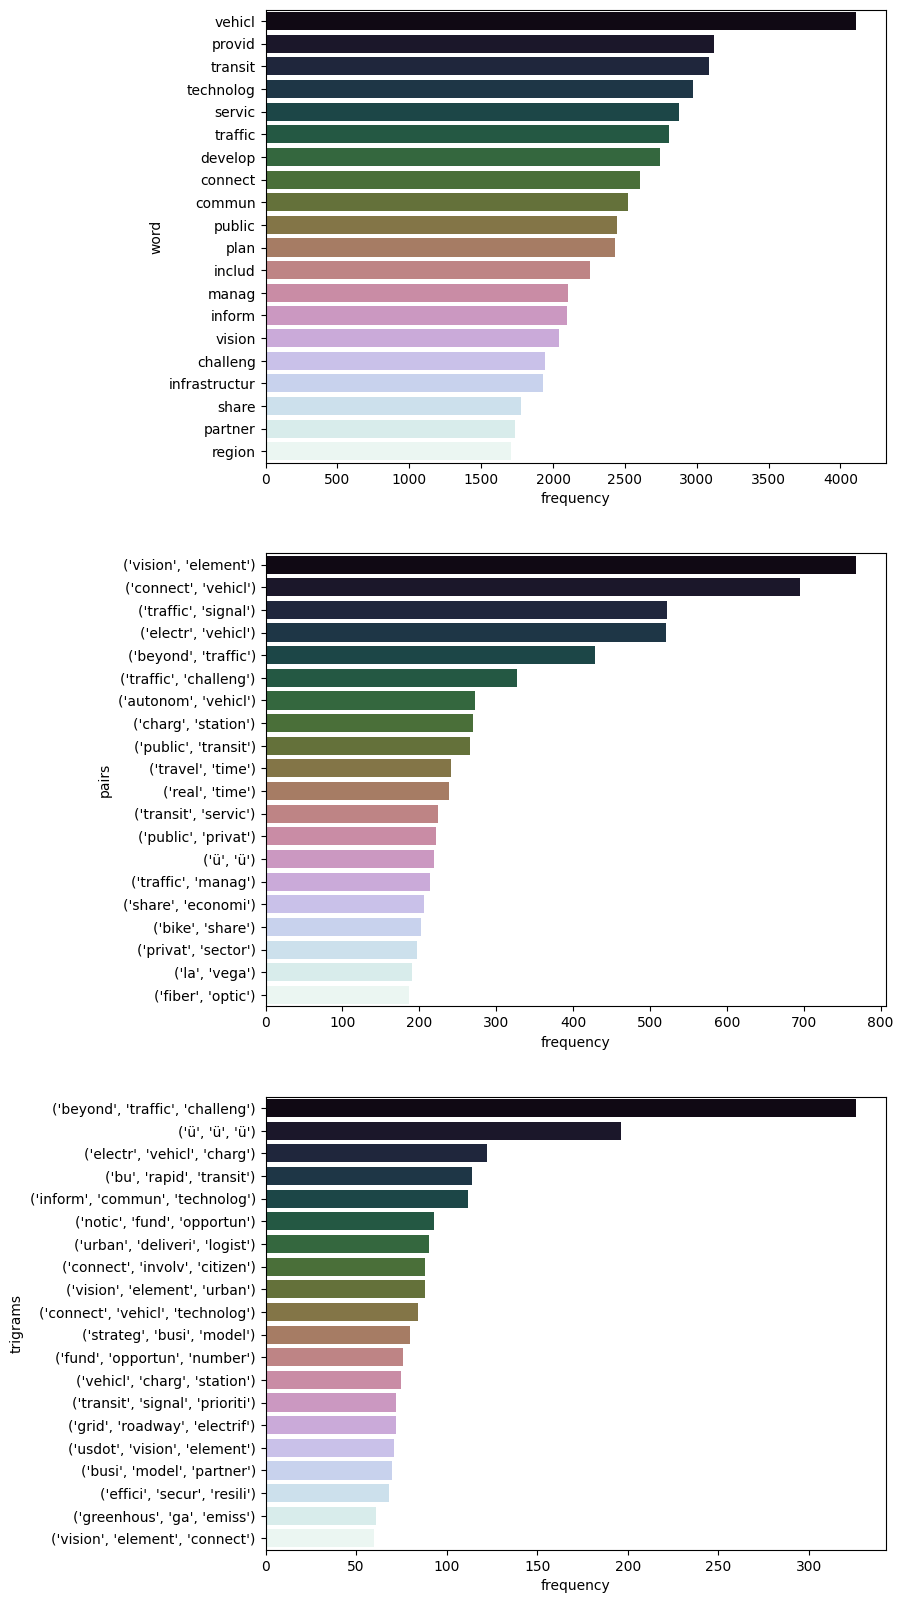

In [8]:
# https://absentdata.com/python-graphs/python-word-frequency/


#counts the words, pairs and trigrams
counted = Counter(list_of_words)
counted_2= Counter(ngrams(list_of_words,2))
counted_3= Counter(ngrams(list_of_words,3))


#creates 3 data frames and returns thems
grams = pd.DataFrame(counted.items(), columns=['word','frequency']).sort_values(by='frequency', ascending=False)
bigrams =pd.DataFrame(counted_2.items(), columns=['pairs','frequency']).sort_values(by='frequency', ascending=False)
trigrams =pd.DataFrame(counted_3.items(), columns=['trigrams','frequency']).sort_values(by='frequency', ascending=False)


# create subplot of the different data frames
fig, axes = plt.subplots(3,1,figsize=(8,20))
sns.barplot(ax=axes[0], x = 'frequency', y = 'word', data = grams.head(20), palette = "cubehelix")
sns.barplot(ax=axes[1], x = 'frequency', y = 'pairs', data = bigrams.head(20), palette = "cubehelix")
sns.barplot(ax=axes[2], x = 'frequency', y = 'trigrams', data = trigrams.head(20), palette = "cubehelix")



### The cleaned text will be retrieved from the dataframe, and joined together in a corpus

In [9]:
corp = []
for doc in supe_clean:
  c = ' '.join(doc)
  corp.append(c)


### Which Smart City applicants did you remove? What issues did you see with the documents?

I did not remove any of the cities. The issues I found with the documents involved words in the document that I removed.



### Explain what additional text processing methods you used and why.

I created a list that contains mostly city names that needed to be removed, because they used their city name very frequently within the document. As a matter of fact, I just caught one while writing this. "minneapolis saint paul"



### Did you identify any potientally problematic words?








### A CountVectorizer and TfidfVectorizer were fit to the cleaned text, and used for analysis. The analysis provided better results with the CountVectorizer, so I will be using the CountVectorizer with ngram_range=(1,2) for this analysis.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
#vectorizer = TfidfVectorizer(ngram_range=(1,2))

vectorizer = CountVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(corp)
feature_names = vectorizer.get_feature_names_out()


In [11]:
print(X.shape[1], 'features were found within the corpus')

264595 features were found within the corpus


### The features were extracted to a dataframe for analysis

In [ ]:
#df2 = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())

# Experimenting with Clustering Models


In [27]:

# DBSCAN CLUSTERING
db = DBSCAN(eps=3, min_samples=2).fit(X.toarray())

preds_db = db.fit_predict(X.toarray())


ss_db = silhouette_score(X.toarray(), preds_db)
dbs_db = davies_bouldin_score(X.toarray(), preds_db)
chs_db = calinski_harabasz_score(X.toarray(), preds_db)


db_scores = [ss_db, dbs_db, chs_db]


In [18]:

scores_km = []
scores_hie = []
cluster_size = [9, 18, 36]

for k in cluster_size:

   km = KMeans(n_clusters = k).fit(X.toarray())
   hie = AgglomerativeClustering(n_clusters = k).fit(X.toarray())
   #db = DBSCAN(eps=3, min_samples = 2).fit(X.toarray())

   preds_km = km.fit_predict(X.toarray())

   preds_hie = hie.fit_predict(X.toarray())

   ss_km = silhouette_score(X.toarray(), preds_km)
   dbs_km = davies_bouldin_score(X.toarray(), preds_km)
   chs_km = calinski_harabasz_score(X.toarray(), preds_km)
   
   scores1 = [ss_km, dbs_km, chs_km]
   scores_km.append(scores1)

   ss_hie = silhouette_score(X.toarray(), preds_hie)
   dbs_hie = davies_bouldin_score(X.toarray(), preds_hie)
   chs_hie = calinski_harabasz_score(X.toarray(), preds_hie)

   scores2 = [ss_hie, dbs_hie, chs_hie]
   scores_hie.append(scores2)




## Optimality

In [26]:
# optimize 
test = list(range(3,51))

best_km_model = KMeans(n_clusters = 2, max_iter = 500, n_init = 1, random_state = 2).fit(X.toarray())
preds_km = best_km_model.fit_predict(X.toarray())


best_km_silhouette = silhouette_score(X.toarray(), preds_km)
best_km_dbs = davies_bouldin_score(X.toarray(), preds_km)
best_km_chs = calinski_harabasz_score(X.toarray(), preds_km)

best_km_k = 2
print(best_km_silhouette)
#####################################################################

best_hie_model = AgglomerativeClustering(n_clusters = 2).fit(X.toarray())
preds_hie = best_hie_model.fit_predict(X.toarray())

best_hie_silhouette = silhouette_score(X.toarray(), preds_hie)
best_hie_dbs = davies_bouldin_score(X.toarray(), preds_hie)
best_hie_chs = calinski_harabasz_score(X.toarray(), preds_hie)

best_hie_k = 2
print(best_hie_silhouette)
#####################################################################

for k in test:
   km_model = KMeans(n_clusters = k, max_iter = 500, n_init = 1, random_state = 2).fit(X.toarray())
   preds_km = km_model.fit_predict(X.toarray())

   test_km_silhouette = silhouette_score(X.toarray(), preds_km)
   test_km_dbs = davies_bouldin_score(X.toarray(), preds_km)
   test_km_chs = calinski_harabasz_score(X.toarray(), preds_km)   

   if test_km_silhouette > best_km_silhouette:
     best_km_model = km_model
     best_km_silhouette = test_km_silhouette
     best_km_k = k

   if test_km_dbs < best_km_dbs:
     best_km_dbs = test_km_dbs

   if test_km_chs < best_km_chs:
     best_km_chs = test_km_chs
####################################################################

   hie_model = AgglomerativeClustering(n_clusters = k).fit(X.toarray())
   preds_hie = hie_model.fit_predict(X.toarray())

   test_hie_silhouette = silhouette_score(X.toarray(), preds_km)
   test_hie_dbs = davies_bouldin_score(X.toarray(), preds_km)
   test_hie_chs = calinski_harabasz_score(X.toarray(), preds_km)   

   if test_hie_silhouette > best_hie_silhouette:
     best_hie_model = hie_model
     best_hie_silhouette = test_hie_silhouette
     best_hie_k = k

   if test_hie_dbs < best_hie_dbs:
     best_hie_dbs = test_hie_dbs

   if test_hie_chs < best_hie_chs:
     best_hie_chs = test_hie_chs

  


0.1680386029084044
0.07629359714156606


In [59]:
Algorithm = ['K-means','Hierarchical','DBSCAN']

scores_km[0] = [round(value, 2) for value in scores_km[0]]
scores_km[1] = [round(value, 2) for value in scores_km[1]]
scores_km[2] = [round(value, 2) for value in scores_km[2]]

scores_hie[0] = [round(value, 2) for value in scores_hie[0]]
scores_hie[1] = [round(value, 2) for value in scores_hie[1]]
scores_hie[2] = [round(value, 2) for value in scores_hie[2]]

k_9 = [scores_km[0], scores_hie[0], 'X']
k_18 = [scores_km[1], scores_hie[1], 'X']
k_36 = [scores_km[2], scores_hie[2], 'X']

hier = [best_hie_silhouette, best_hie_dbs, best_hie_chs]
kme = [best_km_silhouette, best_km_dbs, best_km_chs]
db_scores

hier = [round(value, 2) for value in hier]
kme = [round(value, 2) for value in kme]
db_scores = [round(value, 2) for value in db_scores]



optimal = [kme, hier, db_scores]

In [63]:
print('Algorithm            K=9                  K=18                K=36            Optimal K')
print('Kmeans       ', scores_km, optimal[0])
print('Hierarchical ', scores_hie, optimal[1])
print('DBSCAN               X                     X                   X         ', optimal[2])



Algorithm            K=9                  K=18                K=36            Optimal K
Kmeans        [[0.08, 2.04, 3.05], [0.05, 0.91, 2.63], [0.09, 0.9, 2.97]] [0.17, 0.68, 1.79]
Hierarchical  [[0.05, 1.78, 3.31], [0.07, 1.27, 2.95], [0.08, 0.93, 3.15]] [0.16, 0.68, 1.98]
DBSCAN               X                     X                   X          [-0.0, 1.05, 4.19]
2
4


### How did you approach finding the optimal k?
I created a list with that contains the test clusters with range(3,51), meaning it contains the numbers 3-50. I built an initial model for the cluster methods with the cluster size = 2, and saved the model/silhouette score as the best model/score. I then iterated through the list of test clusters, calculated the silhouette score, and tested the new score against the best score. If the new silhouette score was higher than the best score, I replaced the overall best model and best score.


### What algorithm do you believe is the best? Why?
I think the optimized Kmeans algorithm is the best. When Experimenting with the clusters before optimizing the number of clusters, I liked the results that 2 clusters provided. When Optimizing the clusters, the silhouette score showed the best algorithm is Kmeans with 2 clusters

# Add Cluster ID to output file

In [86]:
df['labels'] = best_km_model.labels_

# Save Model

In [88]:
pickle.dump(best_km_model, open('kmeans.pickle', 'wb'))

# Deriving Themes and Concepts

### A Latent Dirichlet Allocation was fit to the data for a Topic Analysis

In [73]:
from sklearn.decomposition import LatentDirichletAllocation
number_of_topics = 2
model = LatentDirichletAllocation(n_components = number_of_topics, random_state = 0)

model.fit(X)

LatentDirichletAllocation(n_components=2, random_state=0)

In [74]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [75]:
display_topics(model, feature_names, 5)

Topic 0:
vehicl provid transit traffic servic
Topic 1:
vehicl technolog connect servic develop


# Extract themes

Topic 1: Provide transit services to solve the traffic problem

Topic 2: Develop services and technologies for a more connectes infrastructure

# Write output data

In [105]:
df.to_csv('smartcity_eda.tsv', sep='\t', escapechar="|")